# Develop post-processing of radii

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import skeliner as sk
import numpy as np
from matplotlib import pyplot as plt

In [3]:
%timeit
mesh_path = './data/720575940564872157.obj'
mesh = sk.io.load_mesh(mesh_path)

In [4]:
%timeit
skel = sk.skeletonize(mesh=mesh)

In [31]:
%timeit
sk.post.calibrate_radii(
    skel=skel, mesh_vertices=mesh.vertices, verbose=True,
    min_samples_split=20,
    bimodal_kws=dict(
        min_inner_frac= 0.05,
        max_inner_frac= 0.30,
        gap_threshold= 1.5,
        min_cluster_size= 5,
        kmeans_tol= 1e-6,
        max_kmeans_iter= 20,
        verbose=False,
    )
)

[skeliner] calibrate_radii – N=1898, n_fallback=12=1%, n_full_centerline=1822=96%, n_outer_centerline=64=3%; store='calibrated', base='trim'


In [32]:
np.unique(skel.extra['calibration']['radius_method'], return_counts=True)

(array(['fallback', 'full_centerline', 'outer_centerline'], dtype='<U16'),
 array([  12, 1822,   64]))

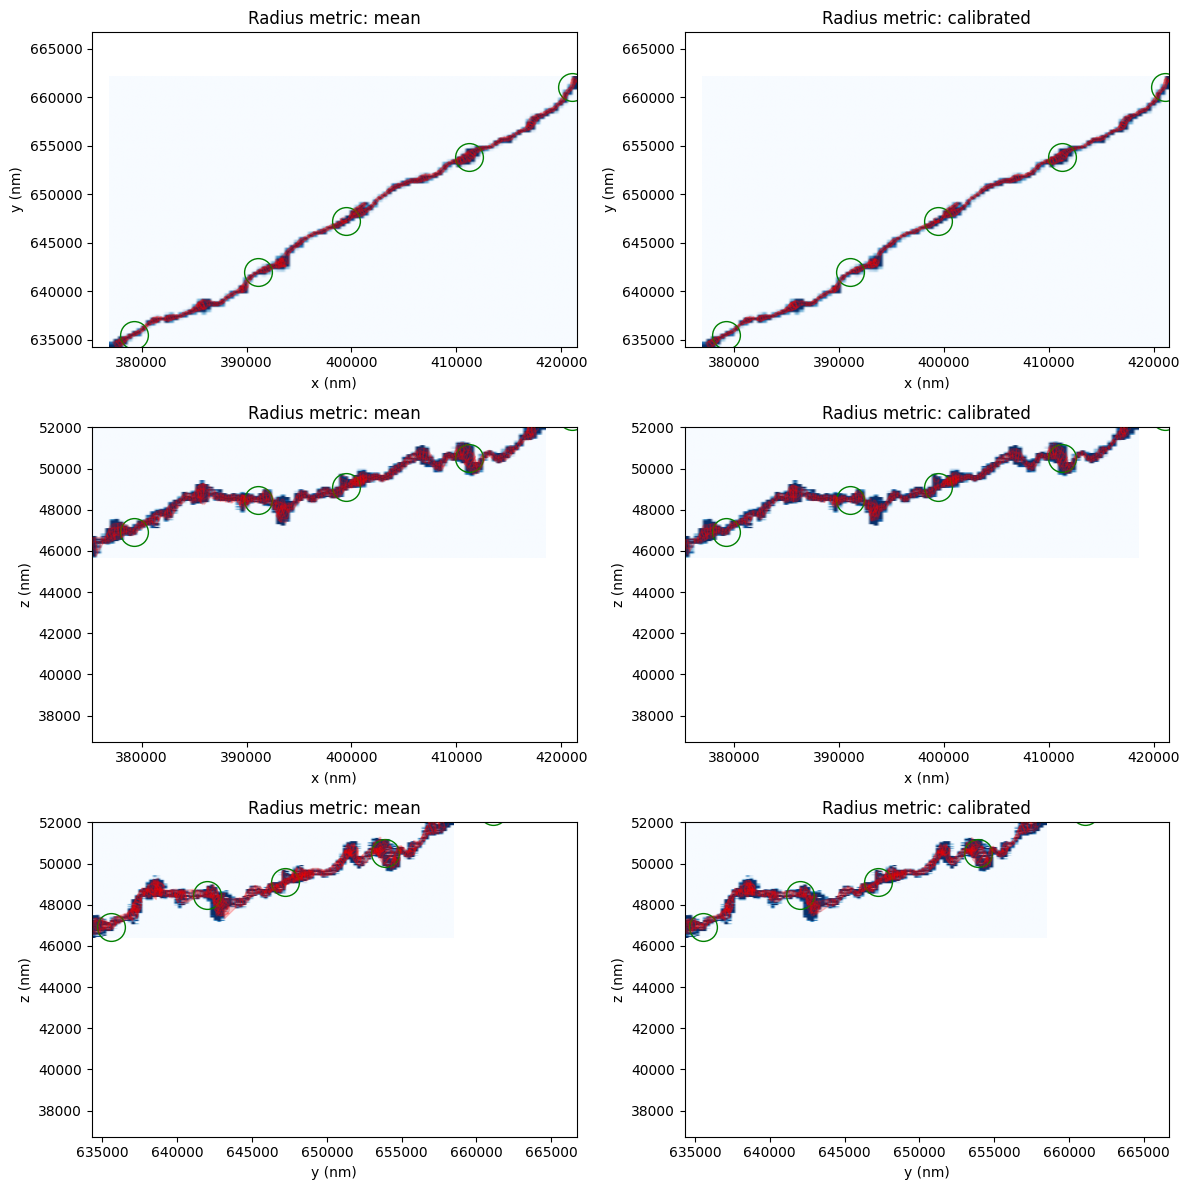

In [33]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
for i, metric in enumerate(['mean', 'calibrated']):
    x_rng = skel.nodes[:, 0].max() - skel.nodes[:, 0].min()
    y_rng = skel.nodes[:, 1].max() - skel.nodes[:, 1].min()
    z_rng = skel.nodes[:, 2].max() - skel.nodes[:, 2].min()

    xlim = skel.soma.center[0] - x_rng *0.05 + 0.1*x_rng, skel.soma.center[0] + x_rng *0.05 + 0.1*x_rng
    ylim = skel.soma.center[1] - y_rng *0.05 + 0.1*y_rng, skel.soma.center[1] + y_rng *0.05 + 0.1*y_rng
    zlim = skel.soma.center[2] - z_rng *0.2, skel.soma.center[2] + z_rng*0.2

    for j, plane in enumerate(['xy', 'xz', 'yz']):
        ax = axs[j, i]
        if plane == 'xy':
            xlim_j, ylim_j = xlim, ylim
        elif plane == 'xz':
            xlim_j, ylim_j = xlim, zlim
        elif plane == 'yz':
            xlim_j, ylim_j = ylim, zlim
        else:
            raise ValueError(f"Unknown plane: {plane}")

        sk.plot.projection(ax=ax, skel=skel, mesh=mesh, plane=plane, radius_metric=metric, draw_cylinders=True,
                           bins=101, xlim=xlim_j, ylim=ylim_j, cylinder_alpha=0.2)

        for ni in range(skel.nodes.shape[0]):
            if skel.extra['calibration']['radius_method'][ni] == 'outer_centerline':
                n_xyz = skel.nodes[ni]
                if plane == 'xy':
                    ax.plot(n_xyz[0], n_xyz[1], 'go', markersize=20, mfc='none')
                elif plane == 'xz':
                    ax.plot(n_xyz[0], n_xyz[2], 'go', markersize=20, mfc='none')
                elif plane == 'yz':
                    ax.plot(n_xyz[1], n_xyz[2], 'go', markersize=20, mfc='none')



        ax.set_aspect('auto', 'box')
        ax.set_title(f"Radius metric: {metric}")

plt.show()

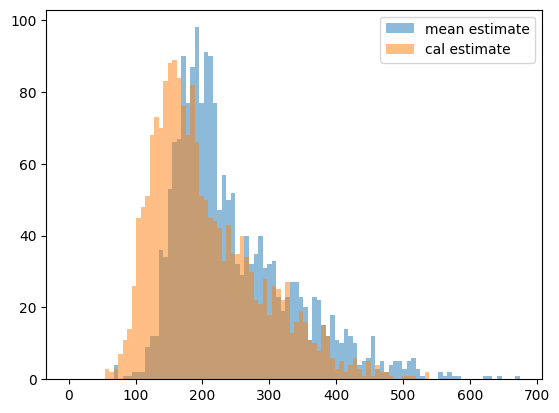

In [34]:
bins = np.linspace(0, np.max(skel.radii['mean']), 101)
plt.hist(skel.radii['mean'], alpha=0.5, bins=bins, label='mean estimate')
plt.hist(skel.radii['calibrated'], alpha=0.5, bins=bins, label='cal estimate')
plt.legend()
plt.show()

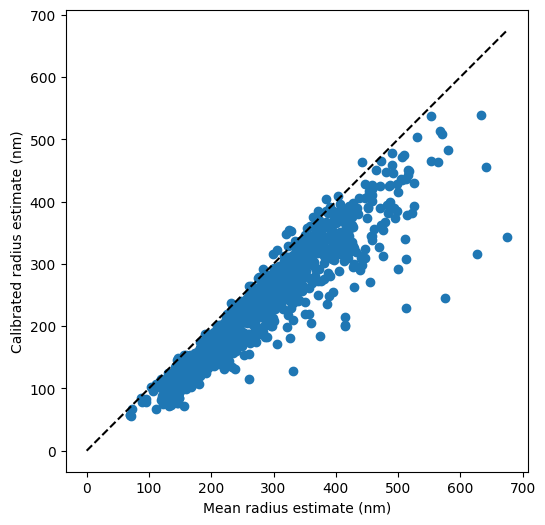

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(skel.radii['mean'], skel.radii['calibrated'])
ax.set_aspect('equal', 'box')
ax.plot([0, skel.radii['mean'].max()], [0, skel.radii['mean'].max()], 'k--')
ax.set(xlabel='Mean radius estimate (nm)', ylabel='Calibrated radius estimate (nm)')
plt.show()